## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


### Imports

In [24]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
import geopandas as gpd
from geopandas import GeoDataFrame
import pickle

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

## Creating and cleaning dataframe

In [25]:
df = pd.read_csv('data/kc_house_data.csv')

### Cleaning DF

- Converting 'waterfront', 'greenbelt', and 'nuisance' into dummy categories
- Applying numerical dictionaries to categorical values for 'view' and 'condition'
- Seperating grade_number and grade_description from grade
- Creating dummy values for heating types
- Splitting Address into relevant columns

In [26]:
df = df.loc[df['long'] > -125]                                                # Remove Hawaii and Alaska
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)           # Converting dates to datetime

### Splitting address into columns
df['City'] = df.address.str.split(',', expand = True)[1]
df['Street'] = df.address.str.split(',', expand = True)[0]
df['State_Zip'] = df.address.str.split(',', expand = True)[2]
df['State_Zip'] = df['State_Zip'].str.strip()
df['Country'] = df.address.str.split(',', expand = True)[3]
df['State'] = df.State_Zip.str.split(' ', expand = True)[0]
df['Zip'] = df.State_Zip.str.split(' ', expand = True)[1]

df = df.drop(columns=['State_Zip', 'address'])
df = df[df['State'] == "Washington"]

### Adding dummies to Y/N columns
dummy_cols = ['waterfront', 'greenbelt','nuisance']
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
### Intsantiate and apply conversion dictionaries
view_dict = {'NONE': 0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
condition_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}
df['view'] = df['view'].map(view_dict)
df['condition'] = df['condition'].map(condition_dict)

### Seperate grade as rank and desc 
df['grade_number'] = df['grade'].str[0].astype('int')
df['grade_description'] = df['grade'].str[2:]

df['Zip'] = df['Zip'].astype('int')

### Making dummy values for heating types
df['heat_source'] = df['heat_source'].fillna("None")
df['heat_elec'] = df['heat_source'].str.contains('Electricity').astype(int)
df['heat_solar'] = df['heat_source'].str.contains('Solar').astype(int)
df['heat_gas'] = df['heat_source'].str.contains('Gas').astype(int)
df['heat_oil'] = df['heat_source'].str.contains('Oil').astype(int)
df['heat_other'] = df['heat_source'].str.contains('Other').astype(int)
df['heat_none'] = df['heat_source'].str.contains('None').astype(int)

## DATA EXPLORATION

### Understanding/viewing the dataframe

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 29200 non-null  int64         
 1   date               29200 non-null  datetime64[ns]
 2   price              29200 non-null  float64       
 3   bedrooms           29200 non-null  int64         
 4   bathrooms          29200 non-null  float64       
 5   sqft_living        29200 non-null  int64         
 6   sqft_lot           29200 non-null  int64         
 7   floors             29200 non-null  float64       
 8   view               29200 non-null  int64         
 9   condition          29200 non-null  int64         
 10  grade              29200 non-null  object        
 11  heat_source        29200 non-null  object        
 12  sewer_system       29200 non-null  object        
 13  sqft_above         29200 non-null  int64         
 14  sqft_b

In [28]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,City,Street,Country,State,Zip,waterfront_YES,greenbelt_YES,nuisance_YES,grade_number,grade_description,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,0,3,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,47.461975,-122.19052,Renton,2102 Southeast 21st Court,United States,Washington,98055,0,0,0,7,Average,0,0,1,0,0,0
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,2,2,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,47.711525,-122.35591,Seattle,11231 Greenwood Avenue North,United States,Washington,98133,0,0,1,7,Average,0,0,0,1,0,0
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,2,2,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,47.502045,-122.22520,Seattle,8504 South 113th Street,United States,Washington,98178,0,0,0,7,Average,0,0,1,0,0,0
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,2,2,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,47.566110,-122.29020,Seattle,4079 Letitia Avenue South,United States,Washington,98118,0,0,0,9,Better,0,0,1,0,0,0
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,0,2,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,47.532470,-122.07188,Issaquah,2193 Northwest Talus Drive,United States,Washington,98027,0,0,1,7,Average,1,0,0,0,0,0


In [29]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,waterfront_YES,greenbelt_YES,nuisance_YES,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
id,1.000000,-0.030230,-0.005589,-0.012323,-0.028343,-0.121079,0.034461,-0.007463,-0.009883,-0.022818,-0.015892,-0.007454,-0.042665,0.022683,-0.029172,-0.000567,0.007312,-0.004385,-0.035805,0.056740,-0.052827,0.035782,-0.065571,0.005090,0.070502,-0.018755,-0.013777,NaN
price,-0.030230,1.000000,0.291044,0.488052,0.616781,0.086805,0.199113,0.321836,-0.012740,0.546154,0.246565,0.267527,0.317613,0.105794,0.085518,0.295968,0.074393,-0.103181,0.239688,0.068352,0.006461,-0.303823,-0.119432,0.023342,0.150821,-0.070960,0.001022,NaN
bedrooms,-0.005589,0.291044,1.000000,0.593462,0.630971,0.000300,0.194348,0.050836,0.019820,0.537928,0.234950,0.305459,0.191700,0.182413,0.010804,-0.016245,0.119309,-0.160532,-0.032387,0.062661,-0.044278,-0.015926,-0.174550,0.009564,0.219898,-0.101039,-0.019739,NaN
bathrooms,-0.012323,0.488052,0.593462,1.000000,0.779854,0.038788,0.427055,0.159391,-0.065627,0.680896,0.260850,0.461303,0.333329,0.455823,0.042598,0.047147,0.163810,-0.171440,0.045763,0.095000,-0.051952,-0.091600,-0.128768,0.026007,0.278952,-0.254313,-0.014872,NaN
sqft_living,-0.028343,0.616781,0.630971,0.779854,1.000000,0.118653,0.354793,0.241815,-0.068968,0.881735,0.336086,0.503718,0.405780,0.328488,0.035437,0.048925,0.213290,-0.188143,0.080701,0.114172,-0.055398,-0.226591,-0.195497,0.019713,0.270102,-0.151275,-0.005768,NaN
sqft_lot,-0.121079,0.086805,0.000300,0.038788,0.118653,1.000000,-0.020766,0.095787,-0.004631,0.128453,0.002433,0.084937,0.157258,0.012296,0.007709,-0.073400,0.168660,-0.094087,0.084213,-0.013872,0.015103,-0.085412,0.078529,-0.001175,-0.077270,0.007649,0.059708,NaN
floors,0.034461,0.199113,0.194348,0.427055,0.354793,-0.020766,1.000000,0.005822,-0.266294,0.504532,-0.243514,0.178559,0.123403,0.521529,-0.015738,0.046329,0.090229,-0.021673,0.002011,0.076061,-0.035772,0.052665,-0.022378,0.020104,0.160711,-0.217225,-0.000825,NaN
view,-0.007463,0.321836,0.050836,0.159391,0.241815,0.095787,0.005822,1.000000,0.027313,0.130217,0.265906,0.024997,0.248700,-0.078335,0.108767,0.008422,-0.042007,0.063773,0.422309,-0.010057,0.028035,-0.130816,0.010833,0.033251,-0.032681,0.033442,0.025778,NaN
condition,-0.009883,-0.012740,0.019820,-0.065627,-0.068968,-0.004631,-0.266294,0.027313,1.000000,-0.152670,0.089833,-0.084594,0.044592,-0.303612,-0.084544,-0.053698,-0.028504,-0.050819,0.002473,-0.032452,-0.016468,-0.006590,0.026515,0.020728,0.005505,-0.044202,-0.001363,NaN
sqft_above,-0.022818,0.546154,0.537928,0.680896,0.881735,0.128453,0.504532,0.130217,-0.152670,1.000000,-0.073572,0.553882,0.320722,0.428004,0.007158,-0.021845,0.310004,-0.256299,0.057455,0.133899,-0.090997,-0.219558,-0.195544,0.006029,0.286893,-0.177219,-0.004118,NaN


### Price vs. Zip Code Boxplot - Top 20 most data per zip code

In [15]:
# fig, ax = plt.subplots(figsize=(12,7))
# df_filtered.boxplot(column = ['sqft_living'])

In [30]:
# df_filtered.corr()

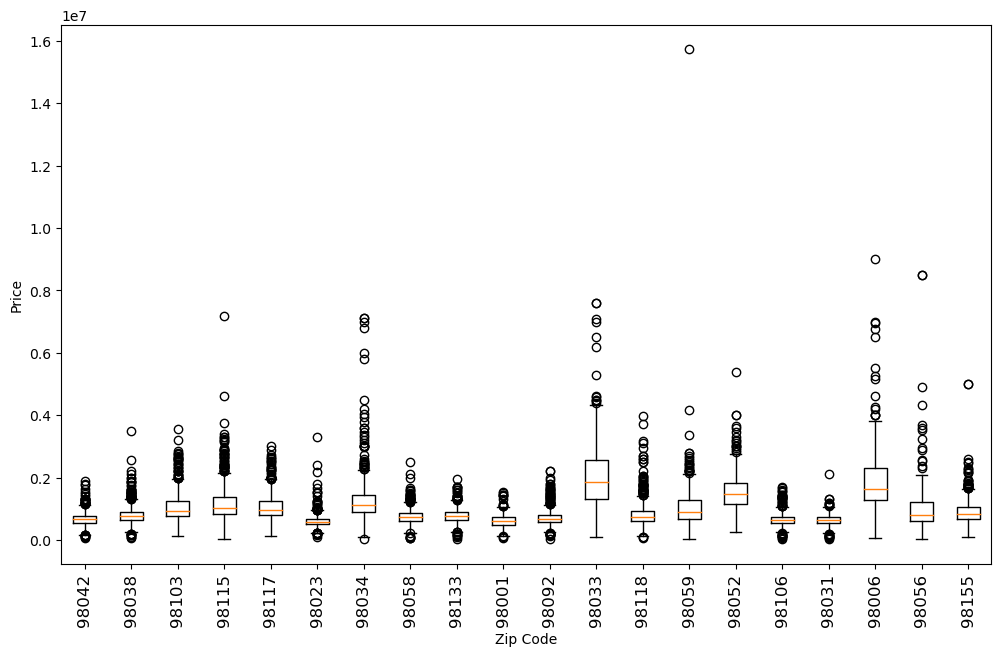

In [31]:
# Box and whiskers of sqft info only
zips = df.Zip.value_counts().index

fig, ax = plt.subplots(figsize=(12,7))
ax.boxplot([df[df.Zip == z]['price'] for z in zips[:20]], labels = zips[:20])
plt.xticks(fontsize=12, rotation=90)
ax.set_xlabel('Zip Code')
ax.set_ylabel('Price')
plt.show()

Amount of homes in each zip code

In [32]:
print(len(df.loc[df['State'] == 'Washington'].Zip.value_counts().tolist()))

92


### Creating a dataframe that only contains numerical values (floats, ints)

In [33]:
num_df = df.select_dtypes(include=[np.float, np.int])      # Create numerical vals df
num_df.head()                                              # View head

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,3,1180,0,0,40,1969,0,47.461975,-122.19052,98055,7,0,0,1,0,0,0
1,8910500230,920000.0,5,2.5,2770,6703,1.0,2,2,1570,1570,0,240,1950,0,47.711525,-122.35591,98133,7,0,0,0,1,0,0
2,1180000275,311000.0,6,2.0,2880,6156,1.0,2,2,1580,1580,0,0,1956,0,47.502045,-122.22520,98178,7,0,0,1,0,0,0
3,1604601802,775000.0,3,3.0,2160,1400,2.0,2,2,1090,1070,200,270,2010,0,47.566110,-122.29020,98118,9,0,0,1,0,0,0
4,8562780790,592500.0,2,2.0,1120,758,2.0,0,2,1120,550,550,30,2012,0,47.532470,-122.07188,98027,7,1,0,0,0,0,0


In [34]:
num_df.info()                                              # View info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29200 non-null  int64  
 1   price          29200 non-null  float64
 2   bedrooms       29200 non-null  int64  
 3   bathrooms      29200 non-null  float64
 4   sqft_living    29200 non-null  int64  
 5   sqft_lot       29200 non-null  int64  
 6   floors         29200 non-null  float64
 7   view           29200 non-null  int64  
 8   condition      29200 non-null  int64  
 9   sqft_above     29200 non-null  int64  
 10  sqft_basement  29200 non-null  int64  
 11  sqft_garage    29200 non-null  int64  
 12  sqft_patio     29200 non-null  int64  
 13  yr_built       29200 non-null  int64  
 14  yr_renovated   29200 non-null  int64  
 15  lat            29200 non-null  float64
 16  long           29200 non-null  float64
 17  Zip            29200 non-null  int64  
 18  grade_

### Creating a pairplot & heatmap for visualization of correlations of values within the numerical df

In [35]:
# sns.pairplot(num_df)

In [36]:
scaler = StandardScaler()
num_df_fitted = scaler.fit_transform(num_df)
fitted_num_df = pd.DataFrame(num_df_fitted, columns=num_df.columns)
# fitted_num_df.corr()

In [37]:
# num_df['scaled_condition'] = num_df['condition']/4
num_df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none
id,1.000000,-0.030230,-0.005589,-0.012323,-0.028343,-0.121079,0.034461,-0.007463,-0.009883,-0.022818,-0.015892,-0.007454,-0.042665,0.022683,-0.029172,-0.000567,0.007312,-0.004385,0.035782,-0.065571,0.005090,0.070502,-0.018755,-0.013777,NaN
price,-0.030230,1.000000,0.291044,0.488052,0.616781,0.086805,0.199113,0.321836,-0.012740,0.546154,0.246565,0.267527,0.317613,0.105794,0.085518,0.295968,0.074393,-0.103181,-0.303823,-0.119432,0.023342,0.150821,-0.070960,0.001022,NaN
bedrooms,-0.005589,0.291044,1.000000,0.593462,0.630971,0.000300,0.194348,0.050836,0.019820,0.537928,0.234950,0.305459,0.191700,0.182413,0.010804,-0.016245,0.119309,-0.160532,-0.015926,-0.174550,0.009564,0.219898,-0.101039,-0.019739,NaN
bathrooms,-0.012323,0.488052,0.593462,1.000000,0.779854,0.038788,0.427055,0.159391,-0.065627,0.680896,0.260850,0.461303,0.333329,0.455823,0.042598,0.047147,0.163810,-0.171440,-0.091600,-0.128768,0.026007,0.278952,-0.254313,-0.014872,NaN
sqft_living,-0.028343,0.616781,0.630971,0.779854,1.000000,0.118653,0.354793,0.241815,-0.068968,0.881735,0.336086,0.503718,0.405780,0.328488,0.035437,0.048925,0.213290,-0.188143,-0.226591,-0.195497,0.019713,0.270102,-0.151275,-0.005768,NaN
sqft_lot,-0.121079,0.086805,0.000300,0.038788,0.118653,1.000000,-0.020766,0.095787,-0.004631,0.128453,0.002433,0.084937,0.157258,0.012296,0.007709,-0.073400,0.168660,-0.094087,-0.085412,0.078529,-0.001175,-0.077270,0.007649,0.059708,NaN
floors,0.034461,0.199113,0.194348,0.427055,0.354793,-0.020766,1.000000,0.005822,-0.266294,0.504532,-0.243514,0.178559,0.123403,0.521529,-0.015738,0.046329,0.090229,-0.021673,0.052665,-0.022378,0.020104,0.160711,-0.217225,-0.000825,NaN
view,-0.007463,0.321836,0.050836,0.159391,0.241815,0.095787,0.005822,1.000000,0.027313,0.130217,0.265906,0.024997,0.248700,-0.078335,0.108767,0.008422,-0.042007,0.063773,-0.130816,0.010833,0.033251,-0.032681,0.033442,0.025778,NaN
condition,-0.009883,-0.012740,0.019820,-0.065627,-0.068968,-0.004631,-0.266294,0.027313,1.000000,-0.152670,0.089833,-0.084594,0.044592,-0.303612,-0.084544,-0.053698,-0.028504,-0.050819,-0.006590,0.026515,0.020728,0.005505,-0.044202,-0.001363,NaN
sqft_above,-0.022818,0.546154,0.537928,0.680896,0.881735,0.128453,0.504532,0.130217,-0.152670,1.000000,-0.073572,0.553882,0.320722,0.428004,0.007158,-0.021845,0.310004,-0.256299,-0.219558,-0.195544,0.006029,0.286893,-0.177219,-0.004118,NaN


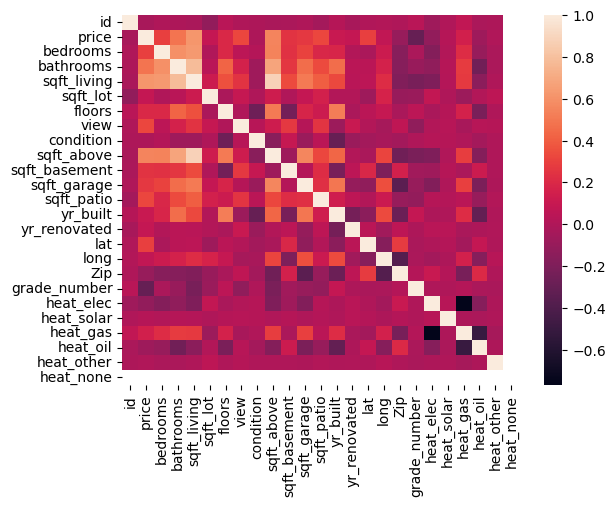

In [38]:
sns.heatmap(num_df.corr())
plt.show()

### Code for later to be used for getting dummies and performing OLS and fits

In [39]:
# y = df['price'].copy()
    
# X_ohe = pd.get_dummies(df.drop(['price'], axis=1), drop_first=False)

# all_mod = sm.OLS(y, sm.add_constant(X_ohe))

In [40]:
# all_results = all_mod.fit()
# print(all_results.summary())

# MAPS

## Continental USA Homes

(22.0, 53.0)

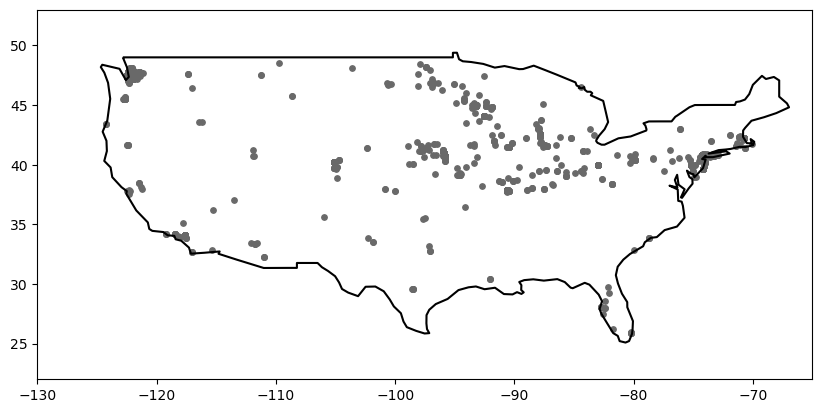

In [41]:
US_df = pd.read_csv('data/kc_house_data.csv')

geometry_USA = gpd.points_from_xy(US_df.long, US_df.lat)                    # Setting the geometry points to be used

gdf_usa = GeoDataFrame(US_df[['lat', 'long']].copy(), geometry=geometry_USA) # Creating necessary GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))   # Accessing the map that comes with geopandas

usa_map = world[world['name'] == 'United States of America']          # Getting map data for USA only

ax = usa_map.boundary.plot(figsize=(10, 10), color='black')           # Setting ax for plotting boundary style map

gdf_usa.plot(ax=ax, marker='o', color='dimgray', markersize=15)           # Plotting the houses on the map as points

ax.set_aspect('equal', 'box')                                         # Setting aspect ratio (long/lat proportion)
ax.set_xlim((-130, -65))                                              # Setting x-limit
ax.set_ylim((22, 53))                                                 # Setting y-limit

## Washington Homes

Map shape source: https://github.com/joncutrer/geopandas-tutorial.git

In [42]:
# DataFrame of only Washington homes
wash_df = df[df['State'] == "Washington"]

EPSG:4326 EPSG:4326


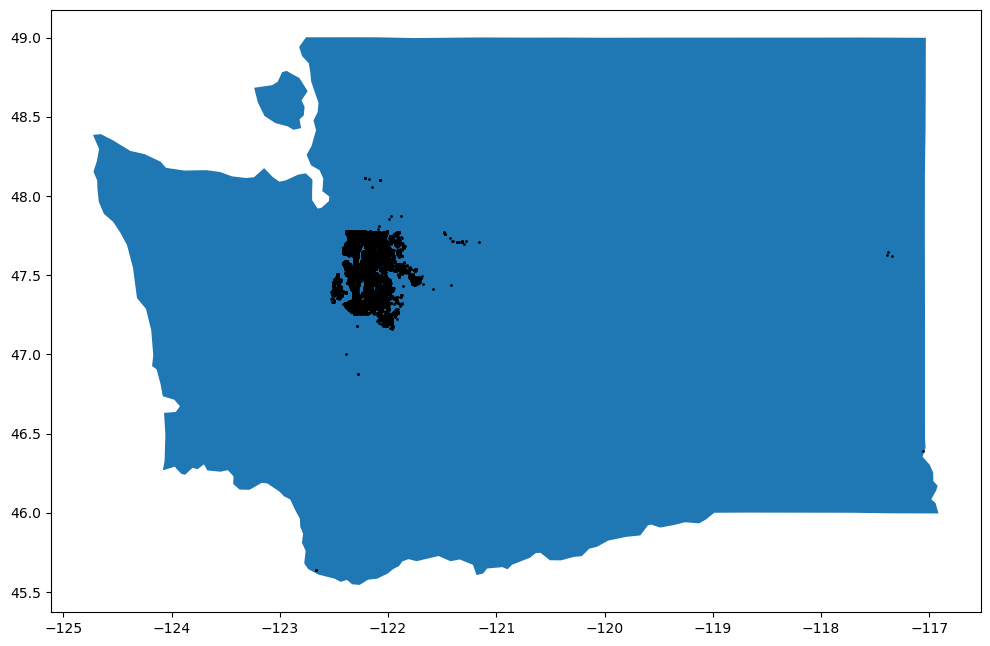

In [43]:
states = gpd.read_file('usa_data/usa-states-census-2014.shp')       # Read in USA map geometry data
w_state = states[states['NAME'] == 'Washington']                    # Get only Washington geometry
new_w_crs = w_state.crs                                             # Get coordinate system of Washington
ax = w_state.plot(figsize=(12,12))                                  # Plot Washington state
geometry_w = gpd.points_from_xy(wash_df.long, wash_df.lat)          # Create geometry of the Washington home data
gdf_w_homes = gpd.GeoDataFrame(wash_df, geometry=geometry_w)                # Create GeoDataFrame with home data and geometry
gdf_w_homes.set_crs(str(new_w_crs), inplace=True)                           # Apply correct coordinate system to home data
print(new_w_crs, gdf_w_homes.crs)                                           # Confirm identical coordinate systems
gdf_w_homes.plot(ax=ax, color='black', markersize=1)                        # Plot home data points onto Washington
plt.show()

## King County Homes

Map shape from census: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

Washington state FP is 53

#### UP NEXT

Use full dataframe in order to access everything by index instead of figuring out the reset_index stuff

Neighboring zip code relationship map colors

In [44]:
# Get the county data and add the geoseries for king county geometry
counties = gpd.read_file('usa_data/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

# County name is 'King' and State code STATEFP is 53 for Washington
king_geometry = counties.loc[(counties.NAME == 'King') & (counties.STATEFP == '53')].geometry

In [45]:
counties.loc[counties.NAME =='King']

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
1036,53,033,01531933,0500000US53033,53033,King,06,5478600963,497675093,"MULTIPOLYGON (((-122.43694 47.66172, -122.4255..."
2476,48,269,01383920,0500000US48269,48269,King,06,2359148814,6398044,"POLYGON ((-100.51869 33.83565, -100.07131 33.8..."


Function to get data from outside King County that needs to be removed.

In [46]:
# Function that takes GeoArray (a list of Point types) and checks if the point is in the county geometry
# Returns an array of Point s to keep, as well as a list of indexes to remove 
# (index according to list, not index name from the pandas dataframe, so reset_index is needed later)

def only_inside_county(points_list, county_geometry):
    rem_idx_list = []
    for idx, x in enumerate(points_list):
        if county_geometry.contains(x).values[0] == False:
            rem_idx_list.append(idx)
    new_points = np.delete(points_list, rem_idx_list)
    return new_points, rem_idx_list

### IMPORTANT: CREATE DATAFRAME WITH ONLY THE VALUES IN KING COUNTY

In [47]:
geometry_k_homes = gpd.points_from_xy(wash_df.long, wash_df.lat)      # Convert WA home points to geoarray of Points
geometry_k_homes, rem_idxs = only_inside_county(geometry_k_homes, 
                                                king_geometry)        # Get the indexes to remove from geoarray

correct_zips_for_county_df = wash_df.reset_index().copy().drop(rem_idxs, axis=0)

### List of zip codes in the data that are in King County

In [50]:
king_county_used_zips = correct_zips_for_county_df['Zip'].value_counts().index.tolist()
king_county_used_zips

[98042,
 98038,
 98115,
 98103,
 98117,
 98023,
 98034,
 98058,
 98133,
 98001,
 98092,
 98033,
 98118,
 98059,
 98052,
 98106,
 98031,
 98006,
 98056,
 98155,
 98125,
 98045,
 98107,
 98022,
 98003,
 98122,
 98144,
 98126,
 98146,
 98074,
 98198,
 98075,
 98199,
 98008,
 98053,
 98116,
 98178,
 98168,
 98027,
 98030,
 98002,
 98040,
 98028,
 98166,
 98072,
 98105,
 98004,
 98029,
 98010,
 98112,
 98108,
 98177,
 98136,
 98065,
 98011,
 98077,
 98019,
 98119,
 98055,
 98188,
 98070,
 98032,
 98005,
 98014,
 98007,
 98102,
 98109,
 98057,
 98024,
 98148,
 98047,
 98051,
 98039,
 98354,
 98288,
 98251,
 98224,
 98050]

EPSG:4269 EPSG:4269


<AxesSubplot:>

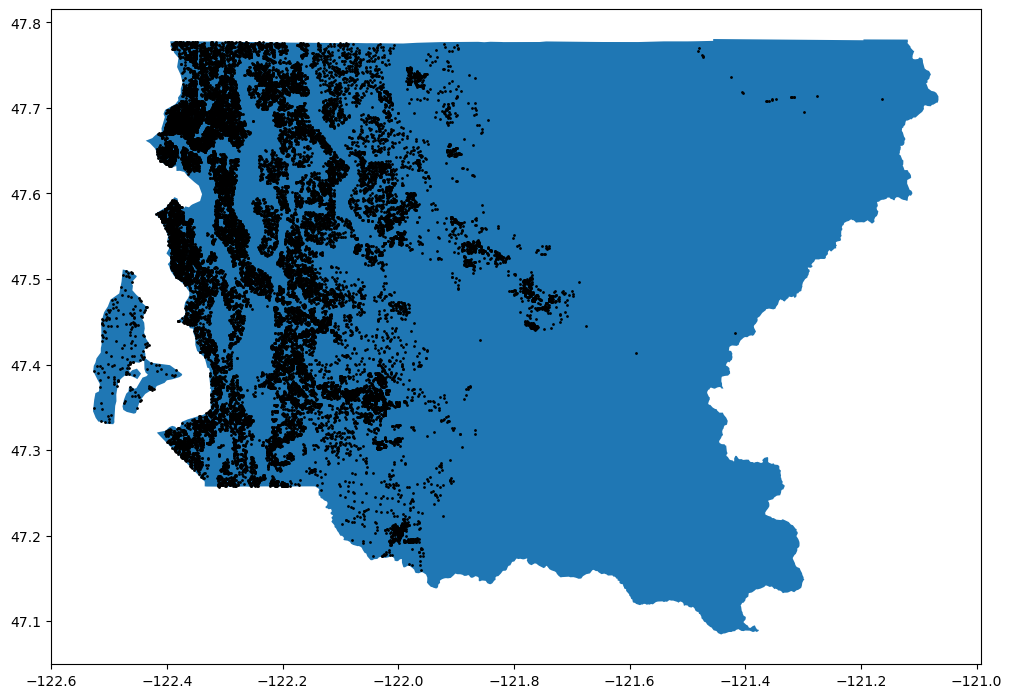

In [51]:
king_crs = king_geometry.crs                 # Get the coordinate system for king county
ax = king_geometry.plot(figsize=(12,12))     # Plot king county


# Reset index of wash_df so that the indexes line up with indexes that need to be remoed from geoarray 'geometry'
# Then drop the indexes by index, instead of original index name by doing reset_index
gdf_k_homes = gpd.GeoDataFrame(correct_zips_for_county_df, geometry=geometry_k_homes)

gdf_k_homes.set_crs(str(king_crs), inplace=True, allow_override=True)     # Set new coordinate system for the data home points

print(king_crs, gdf_k_homes.crs)                     # Ensure coordinate systems are identical

gdf_k_homes.plot(ax=ax, color='black', markersize=1) # Plot the homes onto the county

## Zip Code Homes

In [60]:
# Get the county data and add the geoseries for king county geometry
z_file_path = '../../../../Downloads/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp'
zip_codes = gpd.read_file('../../../../Downloads/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')

In [53]:
zip_codes.loc[zip_codes.ALAND10==5478600963]

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry


In [61]:
all_zips = correct_zips_for_county_df.Zip.value_counts().index.tolist()      # 78 Washington Zip Codes as list
all_zips = [str(x) for x in all_zips]
zip_geometry = zip_codes.loc[zip_codes.ZCTA5CE10.isin(all_zips)].geometry    # The geometries as GeoSeries

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import StrMethodFormatter

In [63]:
TOP_ZIP = str(98144)

In [64]:
zip_r2 = zip_codes.loc[zip_codes.ZCTA5CE10.isin(all_zips)]
type(zip_r2)

zip_r2 = zip_r2.merge(r2_and_zip, how='outer', on='ZCTA5CE10')
zip_r2.fillna(0, inplace=True)
print(type(zip_r2))
zip_r2

NameError: name 'r2_and_zip' is not defined

KeyError: 'r2'

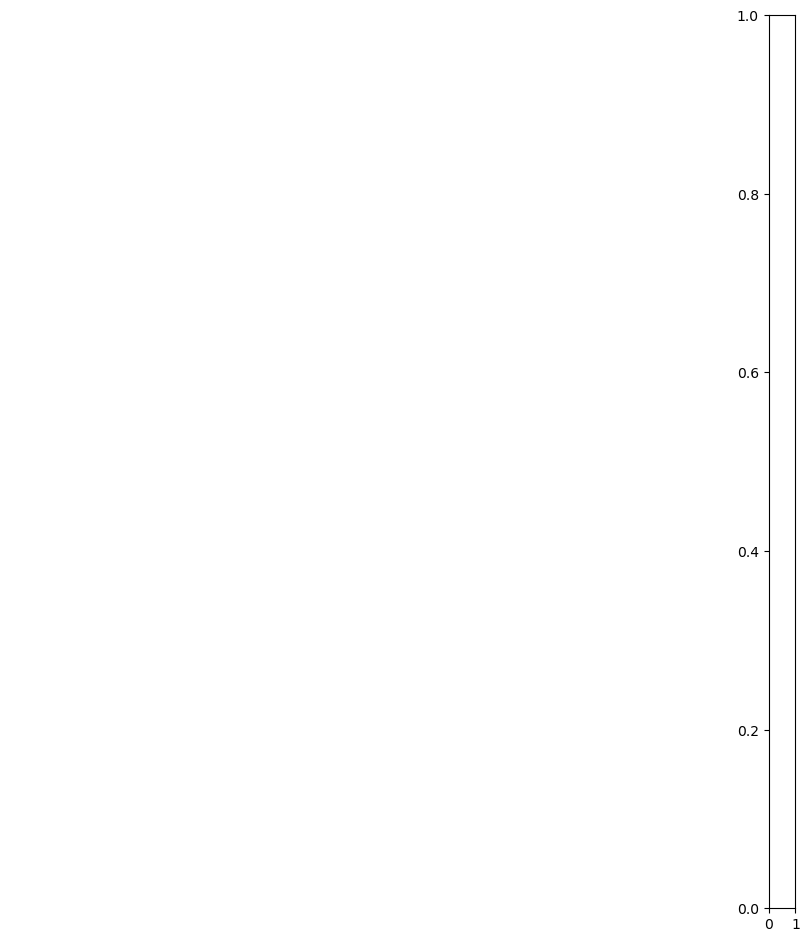

In [59]:
fig, ax = plt.subplots(figsize=(12,12))

# Removes ticks and labels for lat/lon
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 
for pos in ['right', 'top', 'bottom', 'left']:
    ax.spines[pos].set_visible(False)

# make_axes_locatable returns an instance of the AxesLocator class, 
# derived from the Locator. It provides append_axes method that 
# creates a new axes on the given side of (“top”, “right”, 
#“bottom” and “left”) of the original axes.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1, label='Title')


# Plot the GeoDataFrame as a chloropleth
zip_r2.plot(ax=ax, 
            column='r2', # Column that determines color
            legend=True,  
            cmap='inferno',  # Colormap
            cax=cax)      # Add a colorbar


#             edgecolor='black')

# Format colorbar tick labels
# cax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Set the fontsize for each colorbar tick label
# for l in cax.yaxis.get_ticklabels():
#     l.set_fontsize(14)

# ax.set_title('Earthquake Risk in the SF Bay Area', fontsize=20, pad=10);

fig.savefig('zip_code_r2_colormap', transparent=True, dpi=300)

In [84]:
X = num_df[selected_num_cols]
y = num_df['price']

# model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

model = sm.OLS(endog=y, exog=X).fit()

(model.predict([X]) - np.array(num_df['price'])).max()
# model.summary()

4652716.439830754

In [85]:
def get_rsquared(df, cols):
    X = df[cols]
    y = df['price']

    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    
    return model.rsquared, model.mse_resid, model

In [86]:
from itertools import combinations

In [87]:
zips = num_df.Zip.value_counts().index
zip_dict = {code:[0, None] for code in zips[:20]}

print(zip_dict)

{98042: [0, None], 98038: [0, None], 98103: [0, None], 98115: [0, None], 98117: [0, None], 98023: [0, None], 98034: [0, None], 98058: [0, None], 98133: [0, None], 98001: [0, None], 98092: [0, None], 98033: [0, None], 98118: [0, None], 98059: [0, None], 98052: [0, None], 98106: [0, None], 98031: [0, None], 98006: [0, None], 98056: [0, None], 98155: [0, None]}


In [88]:
len([a for a in num_df.Zip.value_counts().tolist() if a > 400])

33

In [89]:
selected_num_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                     'floors', 'bedrooms', 'condition', 'sqft_patio']
zips = num_df.Zip.value_counts().index
zip_dict = {code:[0, None] for code in zips[:33]}


rs_stuff = []
for z in zip_dict.keys():
    for y in range(len(selected_num_cols)):
        for x in combinations(selected_num_cols, y):
            r2, mse, mod = get_rsquared(num_df.loc[num_df.Zip == z], list(x))
            if r2 > zip_dict[z][0]:
                zip_dict[z] = [r2, mod]


In [91]:
def get_rsquared(df, cols):
    X = df[cols]
    y = df['price']

    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    
    return model.rsquared, model.mse_resid, model


def best_r2s(df, cols, min_rows_per_zip):
    
    zips = num_df.Zip.value_counts().index
    num_zips = len([a for a in num_df.Zip.value_counts().tolist() if a > min_rows_per_zip])
    zip_dict = {code:[0, 1e15, None, []] for code in zips[:num_zips]} # key = zip code : val = [r2, mse, model, cols]
    
    
    for z in zip_dict.keys():
        for y in range(len(cols)):
            for x in combinations(cols, y):
                r2, mse, mod = get_rsquared(df.loc[df.Zip == z], list(x))
                if r2 > zip_dict[z][0]:
                    zip_dict[z] = [r2, mse, mod, list(x)]
    return zip_dict


In [92]:
five_cols = best_r2s(num_df, ['sqft_living', 'floors', 'condition', 'grade_number', 'heat_gas'], 300)

In [93]:
r2_current = 0
best_model = None
z = 0

for k, v in five_cols.items():
    if v[0] > r2_current:
        r2_current = v[0]
        best_model = v[2]
        z = k

In [94]:
X = df[['sqft_living', 'floors', 'condition']]
y = df['price']

model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     6003.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:58:41   Log-Likelihood:            -4.3461e+05
No. Observations:               29200   AIC:                         8.692e+05
Df Residuals:                   29196   BIC:                         8.693e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.512e+05   2.24e+04     -6.762      0.000   -1.95e+05   -1.07e+05
sqft_living   572.1006      4.515    126.707      0.000     563.251     580.950
floors      -2.496e+04   8315.973     -3.002      0.003   -4.13e+04   -8663.513
condition    3.318e+04   6044.167      5.489      0.000    2.13e+04     4.5e+04
==============================================================================
Omnibus:                    42301.606   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50547937.926
Skew:                           8.249   Prob(JB):                         0.00
Kurtosis:                     206.160   Cond. No.                     1.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     244.2
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          1.21e-109
Time:                        19:58:41   Log-Likelihood:                -6221.7
No. Observations:                 439   AIC:                         1.245e+04
Df Residuals:                     434   BIC:                         1.247e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.529e+05   1.16e+05      2.177      0.030    2.46e+04    4.81e+05
sqft_living    560.4595     21.663     25.872      0.000     517.882     603.037
floors        4.266e+04   2.74e+04      1.558      0.120   -1.12e+04    9.65e+04
condition     4.609e+04   2.79e+04      1.655      0.099   -8660.386    1.01e+05
grade_number -5.465e+04   1.14e+04     -4.814      0.000    -7.7e+04   -3.23e+04
==============================================================================
Omnibus:                      176.871   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1813.355
Skew:                           1.431   Prob(JB):                         0.00
Kurtosis:                      12.536   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
r2_and_zip = np.zeros((52, 2))

i = 0
for k, v in five_cols.items():
    r2_and_zip[i][0] = k
    r2_and_zip[i][1] = v[0]
    i += 1

r2_and_zip = pd.DataFrame(r2_and_zip, columns=['ZCTA5CE10', 'r2'])
r2_and_zip['ZCTA5CE10'] = r2_and_zip['ZCTA5CE10'].astype(int)
r2_and_zip['ZCTA5CE10'] = r2_and_zip['ZCTA5CE10'].astype(str)

In [165]:
r2_and_zip.loc[r2_and_zip['r2'] > 0.6]

,ZCTA5CE10,r2
26,98144.0,0.692369
34,98053.0,0.602772
47,98029.0,0.627202
49,98112.0,0.683145
51,98177.0,0.618229


In [112]:
print(len(five_cols))

52


In [204]:
five_col_r2 = {}

for k, v in five_cols.items():
    five_col_r2[k] = [v[0], v[3]]

In [205]:
sorted_five = dict(sorted(five_col_r2.items(), key=lambda item: item[1], reverse=True))
sorted_five

{98144: [0.6923691380776158,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98112: [0.683144533599706,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98029: [0.6272017831880277,
  ['sqft_living', 'floors', 'grade_number', 'heat_gas']],
 98177: [0.618229257199688,
  ['sqft_living', 'floors', 'grade_number', 'heat_gas']],
 98053: [0.6027715568739804,
  ['sqft_living', 'condition', 'grade_number', 'heat_gas']],
 98115: [0.5922263838489976,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98105: [0.5910187761357979,
  ['sqft_living', 'floors', 'grade_number', 'heat_gas']],
 98074: [0.5661999511097318,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98008: [0.5587683930508867,
  ['sqft_living', 'floors', 'grade_number', 'heat_gas']],
 98052: [0.5471689928523396,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98092: [0.5414884648262364,
  ['sqft_living', 'floors', 'condition', 'grade_number']],
 98042: [0.5367445833504793,
  ['sqf

In [96]:
for k, v in five_cols.items():
    print(k, '    |    ', round(v[0], 3), '    |    ', round(v[1]), '    |    ', v[3])

98042     |     0.537     |     20985981656     |     ['sqft_living', 'floors', 'condition', 'grade_number']
98038     |     0.425     |     49148784204     |     ['sqft_living', 'condition', 'grade_number', 'heat_gas']
98103     |     0.527     |     95043491127     |     ['sqft_living', 'floors', 'condition', 'grade_number']
98115     |     0.592     |     139982444397     |     ['sqft_living', 'floors', 'condition', 'grade_number']
98117     |     0.497     |     80614551872     |     ['sqft_living', 'floors', 'grade_number', 'heat_gas']
98023     |     0.516     |     26448022691     |     ['sqft_living', 'floors', 'condition', 'grade_number']
98034     |     0.444     |     307199023294     |     ['sqft_living', 'floors', 'grade_number', 'heat_gas']
98058     |     0.473     |     34314476060     |     ['sqft_living', 'floors', 'grade_number', 'heat_gas']
98133     |     0.412     |     32217884410     |     ['sqft_living', 'condition', 'grade_number', 'heat_gas']
98001     |     

In [ ]:
# eight_cols = best_r2s(num_df, selected_num_cols, 400)

In [ ]:
for k, v in eight_cols.items():
    print(k, '    |    ', round(v[0], 3), '    |    ', round(v[1]), '    |    ', v[3])

In [ ]:

r2_high = 0
mse_low = 1e12

r2s = []
mses = []

for i, v in zip_dict.items():
#     print(i, v[0])
    print(i, '      ',   round(v[0],3), '     ', round(v[1].mse_resid))
    r2s.append(v[0])
    mses.append(v[1].mse_resid)
    if v[0] > r2_high:
        r2_high = v[0]
    if v[1].mse_resid < mse_low:
        mse_low = v[1].mse_resid
v[1].predict(X)
num_df.price()
print('R2 HIGH', r2_high)
print('MSE LOW', mse_low)

In [ ]:
plt.scatter(r2s, mses)
plt.xlabel('r^2')
plt.ylabel('MSE')
plt.title('MSE vs. R^2')

In [ ]:
dummy_df = num_df.copy()

dummy_df['avg_price'] = dummy_df['price'].mean()

X = dummy_df['avg_price']
y = dummy_df['price']


dummy_model = sm.OLS(y, sm.add_constant(X)).fit()

print(dummy_model.mse_resid)
dummy_model.summary()

In [ ]:
zip_dict[98122][1].mse_resid

In [ ]:
list(zip_dict.items())[3][1]

In [ ]:
X = num_df.loc[num_df.Zip == 98004][['bathrooms', 'sqft_living', 'sqft_garage']]
y = num_df.loc[num_df.Zip == 98004]['price']

model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

model_summary = model.summary()
model_summary

In [ ]:
rs = []
for y in range(len(selected_num_cols)):
    for x in combinations(selected_num_cols, y):
#         r2 = get_rsquared(num_df.loc[num_df.Zip == 98004], list(x))
        r2 = get_rsquared(num_df.loc[(df['price'] > 1e5) & (df['price'] < 2e6) & (num_df.Zip == 98004)], list(x))
        rs.append(r2)
        print('R^2 is ', r2, 'for', x)
print(rs)

In [ ]:
max(rs)

In [ ]:
X = num_df.drop(columns=['price', 'Zip'])
y = num_df['price']
model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
model.summary()    
#     return model.rsquared

#### There is only one home in some of the zip codes. Stdev has been set to 0 for those

In [245]:
std_num_df = num_df.groupby('Zip')['price', 'sqft_living'].std().fillna(0).reset_index().rename(
    columns={'price': 'price_stdev', 'sqft_living':'sqft_living_stdev'})
std_num_df

,Zip,price_stdev,sqft_living_stdev
0,98001,2.000647e+05,728.828463
1,98002,1.406891e+05,550.454411
2,98003,4.229640e+05,739.255315
3,98004,2.567011e+06,1647.344046
4,98005,9.074782e+05,1158.334509
...,...,...,...
87,98663,3.535534e+03,0.000000
88,99202,0.000000e+00,0.000000
89,99203,0.000000e+00,0.000000
90,99223,0.000000e+00,0.000000


In [246]:
std_and_zip_df = num_df.merge(std_num_df, on='Zip', how='outer')
std_and_zip_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none,price_stdev,sqft_living_stdev
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,3,1180,0,0,40,1969,0,47.461975,-122.190520,98055,7,0,0,1,0,0,0,187388.098955,651.63682
1,3340401570,750000.0,3,2.0,1830,7969,1.0,0,2,930,930,240,90,1950,2008,47.466730,-122.214000,98055,7,0,0,1,0,0,0,187388.098955,651.63682
2,7399301200,728000.0,4,2.0,2170,7520,1.0,0,2,1240,1240,490,60,1973,0,47.463930,-122.189740,98055,7,0,0,1,0,0,0,187388.098955,651.63682
3,9899200050,565000.0,4,2.0,1400,10364,1.5,0,3,1400,0,330,330,1971,0,47.448450,-122.212430,98055,6,1,0,0,0,0,0,187388.098955,651.63682
4,6673070070,645000.0,3,2.0,1520,8250,1.0,0,2,1190,590,420,200,1981,0,47.460870,-122.188690,98055,8,0,0,1,0,0,0,187388.098955,651.63682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29195,2770602496,789995.0,2,2.0,1310,1220,2.0,0,2,840,470,0,310,2013,0,46.389970,-117.056550,99403,8,0,0,1,0,0,0,0.000000,0.00000
29196,1021039039,312750.0,3,2.0,2480,6615,2.0,3,2,1860,620,0,600,1988,0,47.318740,-122.416100,98422,8,1,0,0,0,0,0,0.000000,0.00000
29197,5414100061,679950.0,2,2.0,1170,761,3.0,0,2,1170,0,0,290,2021,0,47.625580,-117.395840,99203,7,1,0,0,0,0,0,0.000000,0.00000
29198,1703400362,879000.0,3,2.0,1610,1005,3.5,0,2,1610,0,0,230,2021,0,47.622819,-117.347162,99223,8,1,0,0,0,0,0,0.000000,0.00000


In [247]:
mean_num_df = num_df.groupby('Zip')['price', 'sqft_living'].mean().fillna(0).reset_index().rename(
    columns={'price': 'price_mean', 'sqft_living':'sqft_living_mean'})
mean_num_df

,Zip,price_mean,sqft_living_mean
0,98001,6.166923e+05,2034.064205
1,98002,4.754262e+05,1543.438017
2,98003,6.067547e+05,1924.588636
3,98004,3.706462e+06,3439.773292
4,98005,2.166382e+06,2889.157303
...,...,...,...
87,98663,5.974500e+05,960.000000
88,99202,7.599500e+05,1020.000000
89,99203,6.799500e+05,1170.000000
90,99223,8.790000e+05,1610.000000


In [248]:
std_and_zip_df = std_and_zip_df.merge(mean_num_df, on='Zip', how='outer')
std_and_zip_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none,price_stdev,sqft_living_stdev,price_mean,sqft_living_mean
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,3,1180,0,0,40,1969,0,47.461975,-122.190520,98055,7,0,0,1,0,0,0,187388.098955,651.63682,6.792782e+05,2003.307339
1,3340401570,750000.0,3,2.0,1830,7969,1.0,0,2,930,930,240,90,1950,2008,47.466730,-122.214000,98055,7,0,0,1,0,0,0,187388.098955,651.63682,6.792782e+05,2003.307339
2,7399301200,728000.0,4,2.0,2170,7520,1.0,0,2,1240,1240,490,60,1973,0,47.463930,-122.189740,98055,7,0,0,1,0,0,0,187388.098955,651.63682,6.792782e+05,2003.307339
3,9899200050,565000.0,4,2.0,1400,10364,1.5,0,3,1400,0,330,330,1971,0,47.448450,-122.212430,98055,6,1,0,0,0,0,0,187388.098955,651.63682,6.792782e+05,2003.307339
4,6673070070,645000.0,3,2.0,1520,8250,1.0,0,2,1190,590,420,200,1981,0,47.460870,-122.188690,98055,8,0,0,1,0,0,0,187388.098955,651.63682,6.792782e+05,2003.307339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29195,2770602496,789995.0,2,2.0,1310,1220,2.0,0,2,840,470,0,310,2013,0,46.389970,-117.056550,99403,8,0,0,1,0,0,0,0.000000,0.00000,7.899950e+05,1310.000000
29196,1021039039,312750.0,3,2.0,2480,6615,2.0,3,2,1860,620,0,600,1988,0,47.318740,-122.416100,98422,8,1,0,0,0,0,0,0.000000,0.00000,3.127500e+05,2480.000000
29197,5414100061,679950.0,2,2.0,1170,761,3.0,0,2,1170,0,0,290,2021,0,47.625580,-117.395840,99203,7,1,0,0,0,0,0,0.000000,0.00000,6.799500e+05,1170.000000
29198,1703400362,879000.0,3,2.0,1610,1005,3.5,0,2,1610,0,0,230,2021,0,47.622819,-117.347162,99223,8,1,0,0,0,0,0,0.000000,0.00000,8.790000e+05,1610.000000


In [252]:
std_and_zip_df['keep_col'] = np.where((std_and_zip_df.price < std_and_zip_df.price_mean + 3 * std_and_zip_df.price_stdev) 
                                      & (std_and_zip_df.price > std_and_zip_df.price_mean - 3 * std_and_zip_df.price_stdev),
                                    True, False)
# std_and_zip_df.shape
std_and_zip_df[std_and_zip_df.keep_col]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none,price_stdev,sqft_living_stdev,price_mean,sqft_living_mean,keep_col
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,3,1180,0,0,40,1969,0,47.461975,-122.190520,98055,7,0,0,1,0,0,0,187388.098955,651.636820,679278.178899,2003.307339,True
1,3340401570,750000.0,3,2.0,1830,7969,1.0,0,2,930,930,240,90,1950,2008,47.466730,-122.214000,98055,7,0,0,1,0,0,0,187388.098955,651.636820,679278.178899,2003.307339,True
2,7399301200,728000.0,4,2.0,2170,7520,1.0,0,2,1240,1240,490,60,1973,0,47.463930,-122.189740,98055,7,0,0,1,0,0,0,187388.098955,651.636820,679278.178899,2003.307339,True
3,9899200050,565000.0,4,2.0,1400,10364,1.5,0,3,1400,0,330,330,1971,0,47.448450,-122.212430,98055,6,1,0,0,0,0,0,187388.098955,651.636820,679278.178899,2003.307339,True
4,6673070070,645000.0,3,2.0,1520,8250,1.0,0,2,1190,590,420,200,1981,0,47.460870,-122.188690,98055,8,0,0,1,0,0,0,187388.098955,651.636820,679278.178899,2003.307339,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,7809400160,199000.0,2,1.0,1150,10098,1.5,2,2,1150,0,0,220,1972,0,47.766720,-121.482380,98224,6,1,0,0,0,0,0,58140.634098,359.304884,254666.666667,890.000000,True
29190,2254501590,999950.0,2,2.0,1330,1318,2.0,0,2,920,410,0,370,2021,0,47.178090,-122.284965,98372,9,1,0,0,0,0,0,130779.399180,113.137085,907475.000000,1250.000000,True
29191,2254501591,815000.0,2,2.0,1170,638,2.0,0,2,780,390,0,320,2021,0,47.178090,-122.284965,98372,9,0,0,1,0,0,0,130779.399180,113.137085,907475.000000,1250.000000,True
29192,3319500313,594950.0,2,2.5,960,640,3.0,0,2,960,0,0,210,2020,0,45.636797,-122.666021,98663,8,1,0,0,0,0,0,3535.533906,0.000000,597450.000000,960.000000,True


In [65]:
########## PROBABLY NOT COMING BACK TO THIS MAPPING CODE ############

# zip_crs = zip_geometry.crs                 # Get the coordinate system for king county
# ax = zip_geometry.plot(cmap='magma', figsize=(12,12))    # Plot king county

# # Reset index of wash_df so that the indexes line up with indexes that need to be remoed from geoarray 'geometry'
# # Then drop the indexes by index, instead of original index name by doing reset_index
# gdf_z_homes = gpd.GeoDataFrame(correct_zips_for_county_df, geometry=zip_geometry)

# gdf_k_homes.set_crs(str(zip_crs), inplace=True)     # Set new coordinate system for the data home points

# print(zip_crs, gdf_z_homes.crs)                     # Ensure coordinate systems are identical

# gdf_z_homes.plot(ax=ax, cmap='hot', markersize=1, legend=True) # Plot the homes onto the county

# fig = ax.get_figure()

# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=1e9))
# # fake up the array of the scalar mappable. Urgh...
# sm_A = [x for x in range(78)]
# fig.colorbar(sm_A, cax=cax)

In [72]:
df['month'] = df['date'].dt.month
df.loc[df.Zip == df.Zip.value_counts().index[0]].month.value_counts()

10    101
4     100
5      97
3      96
8      91
6      89
7      89
9      86
11     79
12     65
2      61
1      38
Name: month, dtype: int64

#### Analyzing 98004 for context

In [71]:
df['month'] = df['date'].dt.month
df.loc[df.Zip == 98004].month.value_counts()

7     40
9     33
5     31
3     29
4     29
10    29
6     27
11    26
8     24
12    23
2     18
1     13
Name: month, dtype: int64

<AxesSubplot:xlabel='month', ylabel='price'>

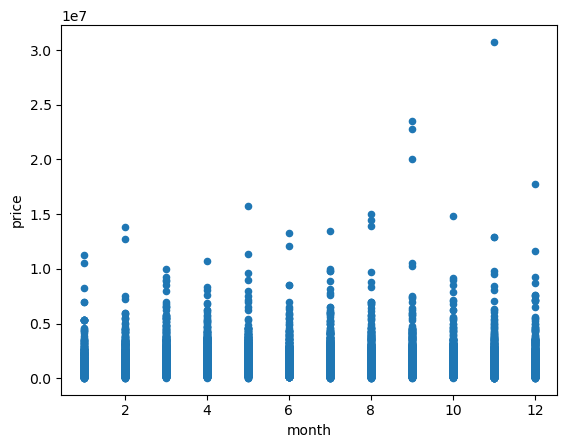

In [73]:
df.plot('month', 'price', kind='scatter')

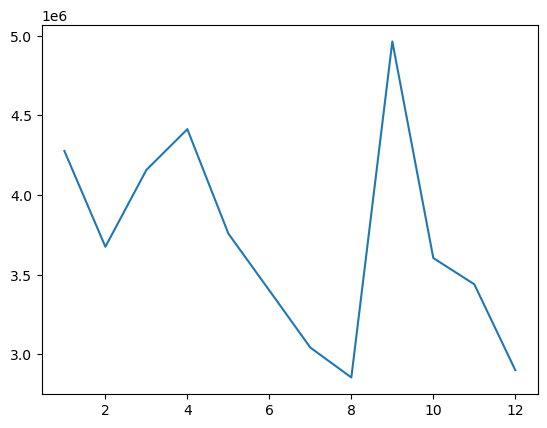

In [74]:
plt.plot(df.loc[df.Zip == 98004].groupby('month')['price'].mean())

In [75]:
df[df.Zip == 98004].corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,Zip,waterfront_YES,greenbelt_YES,nuisance_YES,grade_number,heat_elec,heat_solar,heat_gas,heat_oil,heat_other,heat_none,month
id,1.000000,-0.023307,-0.097185,-0.074522,-0.032172,-0.087415,-0.107099,0.082887,-0.034311,-0.101443,0.100183,-0.013565,0.059952,-0.023455,-0.072909,0.341299,-0.152231,NaN,-0.071553,0.018167,-0.245159,0.058105,0.048993,NaN,0.010778,-0.043911,NaN,NaN,-0.038237
price,-0.023307,1.000000,0.270837,0.524940,0.608688,0.437285,0.194139,0.568319,-0.076755,0.579365,0.198290,0.334252,0.472129,0.349837,0.069203,0.220673,-0.418506,NaN,0.498368,-0.023906,-0.133196,-0.460583,-0.083208,NaN,0.237313,-0.217102,NaN,NaN,-0.083604
bedrooms,-0.097185,0.270837,1.000000,0.681792,0.650864,0.205090,0.325741,0.022921,-0.154762,0.560728,0.282152,0.415297,0.316949,0.448625,-0.046985,0.101873,-0.102367,NaN,-0.130013,0.043644,0.021354,-0.362940,0.073793,NaN,0.191458,-0.266080,NaN,NaN,0.009965
bathrooms,-0.074522,0.524940,0.681792,1.000000,0.865715,0.193103,0.501055,0.148480,-0.175853,0.812986,0.274110,0.603102,0.397647,0.721278,-0.034887,0.105187,-0.150949,NaN,-0.032074,0.021145,-0.030045,-0.608744,0.038498,NaN,0.290919,-0.356800,NaN,NaN,-0.034602
sqft_living,-0.032172,0.608688,0.650864,0.865715,1.000000,0.369830,0.467282,0.221355,-0.141979,0.890062,0.405550,0.624464,0.466038,0.703570,-0.072970,0.143664,-0.197166,NaN,0.009330,-0.023042,-0.061620,-0.657891,-0.040242,NaN,0.343647,-0.366160,NaN,NaN,-0.062613
sqft_lot,-0.087415,0.437285,0.205090,0.193103,0.369830,1.000000,-0.037865,0.351704,0.181655,0.338432,0.192369,0.078713,0.230376,-0.081584,-0.007999,0.154938,-0.303983,NaN,0.296698,-0.075232,0.008934,-0.223839,-0.060420,NaN,0.081681,-0.054219,NaN,NaN,-0.023460
floors,-0.107099,0.194139,0.325741,0.501055,0.467282,-0.037865,1.000000,-0.082147,-0.166286,0.626614,-0.202434,0.393322,0.128177,0.582381,-0.054814,-0.039407,0.099789,NaN,-0.000739,0.016340,0.003530,-0.341602,-0.011541,NaN,0.235257,-0.260998,NaN,NaN,0.053081
view,0.082887,0.568319,0.022921,0.148480,0.221355,0.351704,-0.082147,1.000000,0.071363,0.131260,0.263667,0.022889,0.359007,-0.003926,0.077650,-0.007314,-0.303011,NaN,0.493211,-0.065402,-0.128400,-0.146260,-0.059760,NaN,0.096502,-0.071556,NaN,NaN,-0.006431
condition,-0.034311,-0.076755,-0.154762,-0.175853,-0.141979,0.181655,-0.166286,0.071363,1.000000,-0.175720,-0.003203,-0.173710,0.006139,-0.299215,-0.083943,-0.037351,-0.006685,NaN,0.009460,-0.028971,0.027644,0.129120,-0.011744,NaN,0.051445,-0.051125,NaN,NaN,0.069306
sqft_above,-0.101443,0.579365,0.560728,0.812986,0.890062,0.338432,0.626614,0.131260,-0.175720,1.000000,-0.014513,0.610134,0.340370,0.700867,-0.042788,0.109528,-0.137121,NaN,0.020994,-0.002585,-0.040579,-0.669480,-0.066524,NaN,0.331860,-0.335753,NaN,NaN,-0.030974


In [76]:
df.Zip.value_counts().index

Int64Index([98042, 98038, 98103, 98115, 98117, 98023, 98034, 98058, 98133,
            98001, 98092, 98033, 98118, 98059, 98052, 98106, 98031, 98006,
            98056, 98155, 98125, 98045, 98107, 98022, 98003, 98122, 98144,
            98126, 98146, 98074, 98198, 98075, 98199, 98008, 98053, 98116,
            98178, 98168, 98027, 98030, 98002, 98040, 98028, 98166, 98072,
            98105, 98004, 98029, 98010, 98112, 98108, 98177, 98136, 98065,
            98011, 98077, 98019, 98119, 98055, 98188, 98070, 98032, 98005,
            98014, 98007, 98102, 98109, 98057, 98024, 98148, 98047, 98051,
            98039, 98354, 98288, 98272, 98271, 98223, 98251, 98224, 98050,
            98338, 98372, 98663, 98296, 98387, 99202, 99403, 98422, 99203,
            99223, 98270],
           dtype='int64')